In [1]:
import re
import math
import jieba
import numpy as np
import pandas as pd
from snownlp import SnowNLP
from pyecharts.charts import Pie
from pyecharts.charts import Line
from pyecharts.faker import Faker
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [7]:
# !pip install jieba
# !pip install SnowNLP
# !pip install nltk

In [2]:
data = pd.read_excel('苏宁易购apple.xlsx')
print(data['star'].unique())
data.head()

[5 3 2 1]


,content,star
0,是真品，物流特别快，非常不错,5
1,蓝色挺经典的，满大街都是白色粉色，反而觉得红蓝看着更顺眼了。,5
2,拍照效果好，显示情绪,5
3,女朋友出轨了心情很失落无意间看到了这个颜色的手机给我现在的心情很符合深绿色的手机运行很流畅玩...,5
4,苹果13手机用着真的是非常可以的哦啊，颜值高拍照效果好，大电池续航能力强的。苏宁易购苹果自营...,5


In [3]:
#感情标签
def make_label(star):
    if star > 3:
        return 1
    else:
        return 0
data['sentiment'] = data.star.apply(make_label) #新增一列
data

,content,star,sentiment
0,是真品，物流特别快，非常不错,5,1
1,蓝色挺经典的，满大街都是白色粉色，反而觉得红蓝看着更顺眼了。,5,1
2,拍照效果好，显示情绪,5,1
3,女朋友出轨了心情很失落无意间看到了这个颜色的手机给我现在的心情很符合深绿色的手机运行很流畅玩...,5,1
4,苹果13手机用着真的是非常可以的哦啊，颜值高拍照效果好，大电池续航能力强的。苏宁易购苹果自营...,5,1
...,...,...,...
105,差评，差评，差评。**次差评给了这。买回来一天手机就自动关机，开不了机。8月1号申请换货（还...,1,0
106,电话没有充电器？,1,0
107,服务不满意，太差，太差,1,0
108,此用户没有填写评价内容,1,0


In [4]:
#定义评论
def snow_result(content):
    s = SnowNLP(content)
    if s.sentiments >= 0.6:
        return 1
    else:
        return 0
data['snlp_result'] = data.content.apply(snow_result)
data.head()

,content,star,sentiment,snlp_result
0,是真品，物流特别快，非常不错,5,1,1
1,蓝色挺经典的，满大街都是白色粉色，反而觉得红蓝看着更顺眼了。,5,1,1
2,拍照效果好，显示情绪,5,1,1
3,女朋友出轨了心情很失落无意间看到了这个颜色的手机给我现在的心情很符合深绿色的手机运行很流畅玩...,5,1,1
4,苹果13手机用着真的是非常可以的哦啊，颜值高拍照效果好，大电池续航能力强的。苏宁易购苹果自营...,5,1,1


In [5]:
#分词，content数据预处理
def get_words(ndatas,words=[]):
    for i in range(len(ndatas)):
        # print(data['content'][i])
        text = jieba.lcut(ndatas[i])
        for i in range(len(text)):
            text[i] = re.sub("\d|\s","",text[i])
        words += [x for x in text if x not in '''。@#￥%……&*（！）.@#$%^&*()_?？“‘，,-''' and len(x)>1 and is_Chinese(x)==True]
    # print(words)
    return words

#检测是否是中文字符串
def is_Chinese(word):
    t = open('wyc.txt', encoding= 'utf-8')
    s = t.read()
    li = s.split('\n')
    if '\u4e00' > word or word > '\u9fff' or (word in li):
        return False
    return True

#词频统计
def get_nwords(ndata):
    newhamlet={}#建空字典
    for word in get_words(ndata):
        newhamlet[word]=newhamlet.get(word,0)+1
        # get访问字典中word对应的值,
        # 若存在返回默认值，再+1替换原来的word的值,
        # 若不存在则返回0，则word的值变为1
    items=list(newhamlet.items())
    #items返回字典中所有的键值对，再变成列表返回
    items.sort(key=lambda x:x[1],reverse=True)
    #sort列表排序，reverse=True降序，
    #key=值，所以按值的大小排序，从高频词到低频词
    return items

#点互信息
def get_pmi(ndata,key=[]):
    bigram_measures = BigramAssocMeasures()
    #BigramCollocationFinder.from_words(words, window_size=2): 
    #把词列表变为双词搭配
    #BigramCollocationFinder
    # 它是一个发现二元词组并对其进行排序的工具，
    # 一般使用函数from_words()去构建一个搜索器
    finder = BigramCollocationFinder.from_words(get_words(ndata))
    # print('word1  , word2,  PMI值')
    for row in finder.score_ngrams(bigram_measures.pmi):
        #按pmi值从大到小排序
        #score_ngrams(self, score_fn): 
        # 返回由词组和对应分数组成的序列，并将其从高到低排列。
        datapmi = (*row[0],row[1])
        if len(datapmi[0]) > 1 and  len(datapmi[1]) > 1:
            key.append(row[1])
            print(datapmi)
    return key
    # 点互信息（PMI）关注两个随机变量之间具体取值的关联
    # PMI越大两个随机变量之间的联系越大
    # PMI<0 代表xy和具有互斥关系
    # xy同时出现的情况小于xy分别出现并且恰巧混在一起的情况

In [6]:
key1 = get_pmi(data['content'].tolist())
an = bn = cn = 0
for i in key1:
    if i>0:
        an += 1
    elif i==0:
        bn += 1
    elif i<0:
        cn += 1
print('PMI值')
print("正面倾向：{} 中性倾向：{} 负面倾向：{}".format(an,bn,cn))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\SUGA\AppData\Local\Temp\jieba.cache
Loading model cost 1.158 seconds.
Prefix dict has been built successfully.


('一切正常', '外环', 10.552669097514272)
('一口', '责任', 10.552669097514272)
('一张', '优惠券', 10.552669097514272)
('一机', '一线', 10.552669097514272)
('一根', '头到', 10.552669097514272)
('一款', '同一', 10.552669097514272)
('一点', '问问', 10.552669097514272)
('七天', '没人管', 10.552669097514272)
('上方', '黑屏', 10.552669097514272)
('上端', '两处', 10.552669097514272)
('下午', '主动', 10.552669097514272)
('不上', '诸多', 10.552669097514272)
('不厌其烦', '细致', 10.552669097514272)
('不戴', '比较', 10.552669097514272)
('不用说', '当前', 10.552669097514272)
('不看', '七天', 10.552669097514272)
('不行', '只玩下', 10.552669097514272)
('不起', '各种', 10.552669097514272)
('专员', '回电', 10.552669097514272)
('两处', '明显', 10.552669097514272)
('中午', '点个', 10.552669097514272)
('中规中矩', '重度', 10.552669097514272)
('为了', '保真', 10.552669097514272)
('买到', '假货', 10.552669097514272)
('二次', '跳转', 10.552669097514272)
('人工', '评估', 10.552669097514272)
('仓库', '无货', 10.552669097514272)
('他们', '换组', 10.552669097514272)
('以外', '蓝牙', 10.552669097514272)
('优惠券', '可惜', 10.552669097514272)

In [7]:
#基本统计
counts = 0
for i in range(len(data)):
    if data.iloc[i,2] == data.iloc[i,3]:
        counts += 1
print(counts/len(data))

0.9181818181818182


In [8]:
a = int((data.query('sentiment==1').count())['sentiment'])
b = int((data.query('sentiment==0').count())['sentiment'])
d = (Pie()
     .add(series_name=' ',data_pair=[('正面评论',a),('负面评论',b)])
     .set_global_opts(
        title_opts=opts.TitleOpts(title="情感倾向",subtitle="苏宁易购上Apple iPhone 13产品的评论"),
        legend_opts=opts.LegendOpts(pos_left="30%")
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}")))
d.render_notebook()


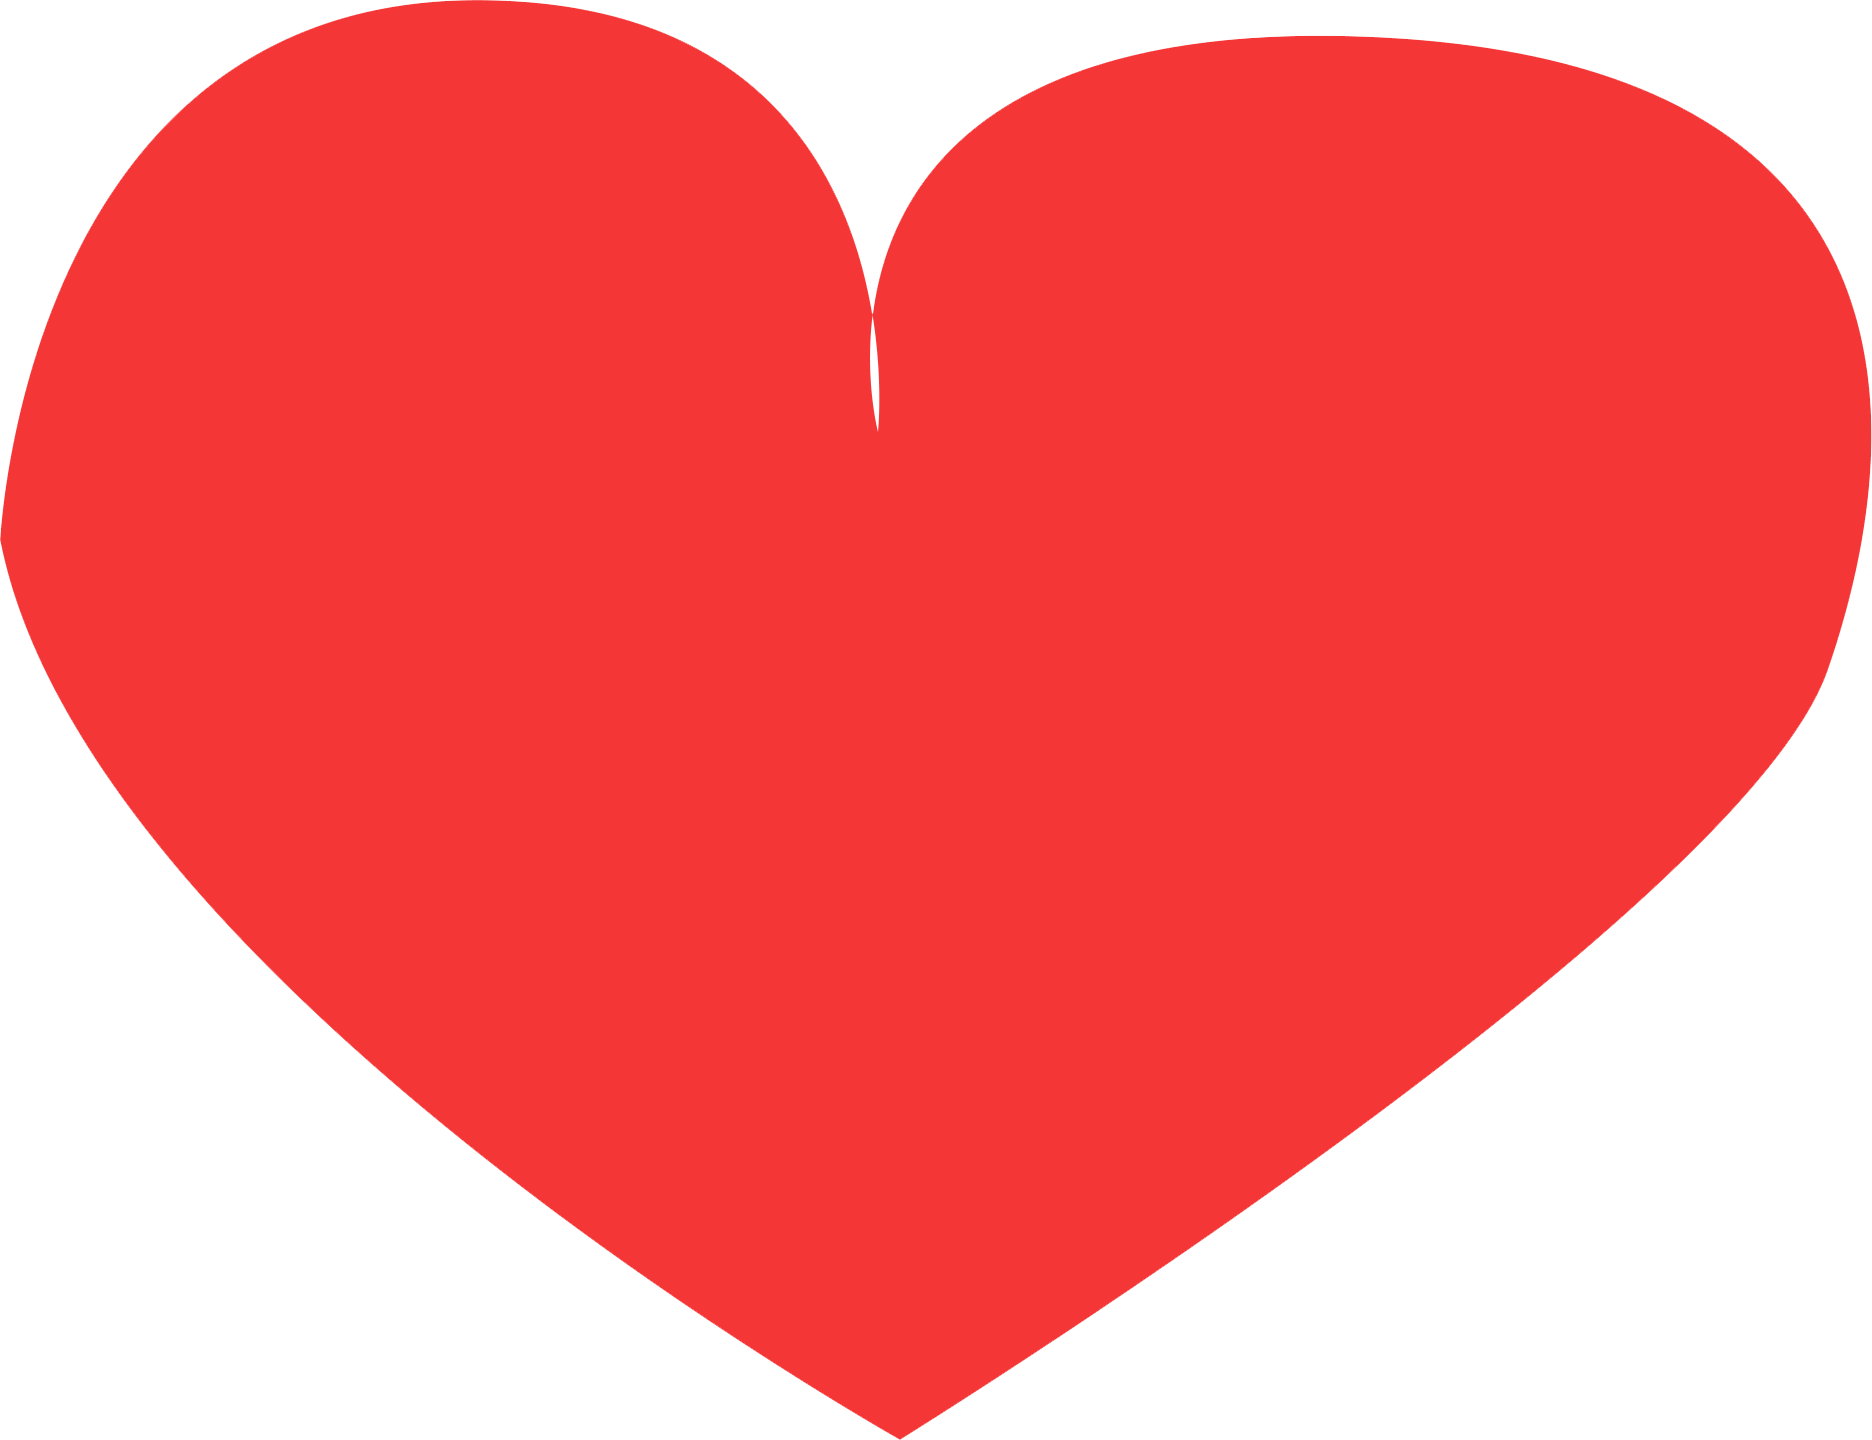

In [9]:
ndatas = data.query('sentiment==1 and snlp_result==1')['content'].tolist()
nitems = get_nwords(ndatas)
c = (
    WordCloud()
    .add("",nitems, word_size_range=[12, 55], mask_image='心形.png')
    .set_global_opts(title_opts=opts.TitleOpts(title="苏宁易购 词云图",subtitle="正面评论关键词"))
)
c.render_notebook()

In [11]:
ndatas = data.query('sentiment==0 and snlp_result==0')['content'].tolist()
nitems0 = get_nwords(ndatas)
c0 = (
    WordCloud()
    .add("",nitems0)
    .set_global_opts(title_opts=opts.TitleOpts(title="苏宁易购 词云图",subtitle="负面评论关键词"))
)
c0.render_notebook()

In [12]:
#京东评论数据分析
data1 = pd.read_excel('京东apple.xlsx')
data1['sentiment'] = data1.star.apply(make_label) #新增一列
data1['snlp_result'] = data1.content.apply(snow_result)

#基本统计
counts1 = 0
for i in range(len(data1)):
    if data1.iloc[i,2] == data1.iloc[i,3]:
        counts1 += 1
print(counts1/len(data1))

data1.head()

0.7727272727272727


,content,star,sentiment,snlp_result
0,物流速度快，京东好品质,3,0,1
1,手机刚到手用段时间再评价,3,0,1
2,活动价格给力，发货次日就收到了,3,0,0
3,东西挺好用的，但第八天降价1000搞人心态,3,0,1
4,品控仍有瑕疵，但可以接受,3,0,1


In [13]:
a1 = int((data1.query('sentiment==1').count())['sentiment'])
b1 = int((data1.query('sentiment==0').count())['sentiment'])
d1 = (Pie()
     .add(series_name=' ',data_pair=[('正面评论',a1),('负面评论',b1)])
     .set_global_opts(
        title_opts=opts.TitleOpts(title="情感倾向",subtitle="京东上Apple iPhone 13产品的评论"),
        legend_opts=opts.LegendOpts(pos_left="30%"),toolbox_opts=opts.ToolboxOpts()
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}")))
d1.render_notebook()


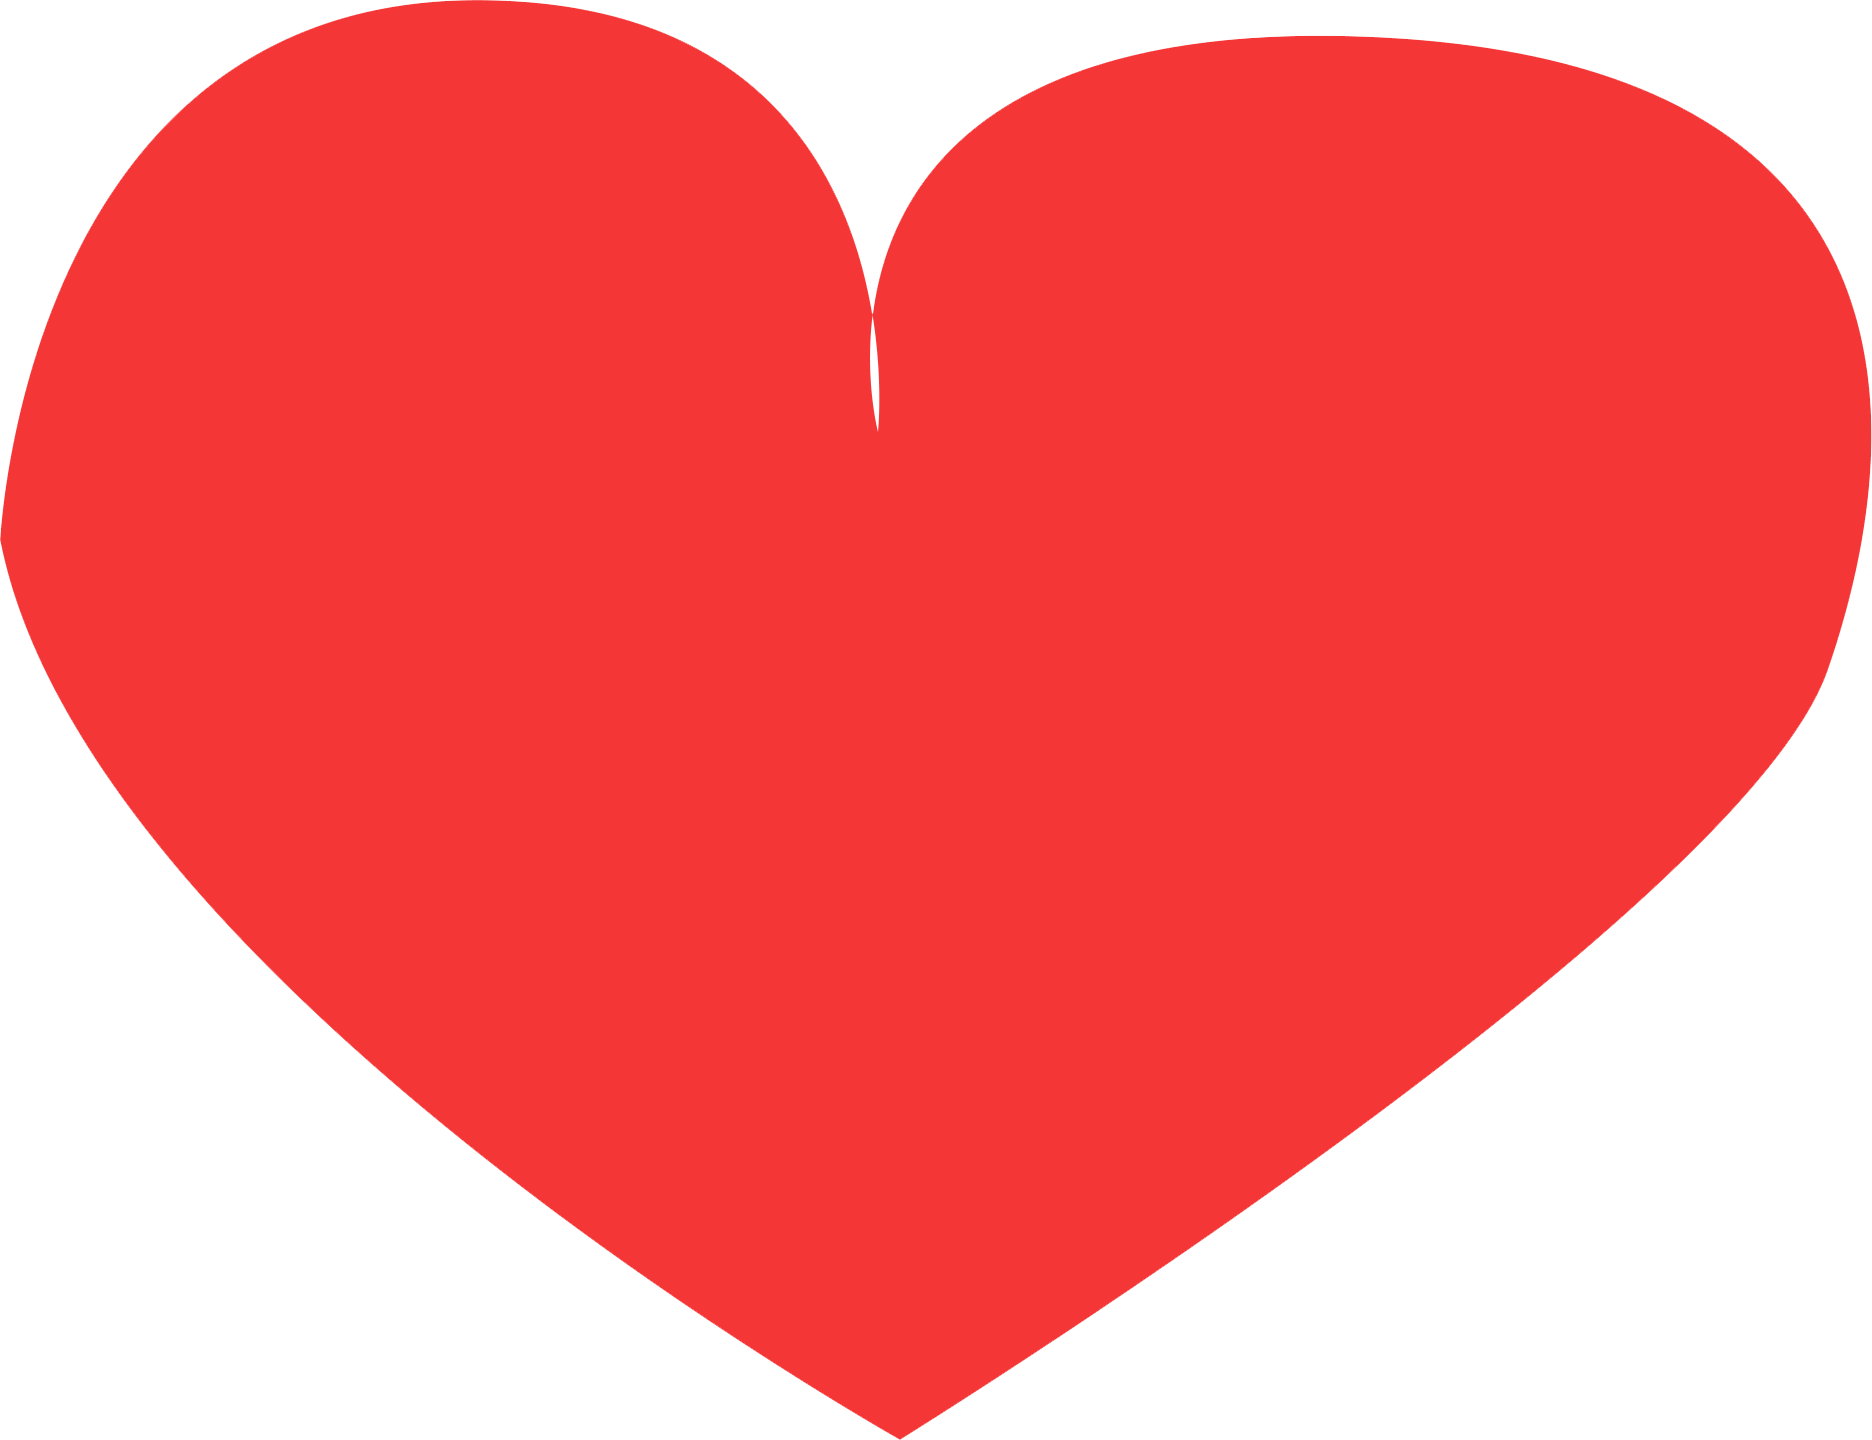

In [14]:
nitems1 = get_nwords(data.query('sentiment==1 and snlp_result==1')['content'].tolist())
c1 = (
    WordCloud()
    .add("",nitems1, word_size_range=[12, 55], mask_image='心形.png')
    .set_global_opts(title_opts=opts.TitleOpts(title="京东 词云图",subtitle="对Apple iPhone 13产品评论关键词"))
)
c1.render_notebook()

In [15]:
key2 = get_pmi(data1['content'].tolist())
aj = bj = cj = 0
for i in key2:
    if i>0:
        aj += 1
    elif i==0:
        bj += 1
    elif i<0:
        cj += 1
print(aj,bj,cj)

('一份', '保障', 12.583552930466485)
('一切', '恢复', 12.583552930466485)
('一言难尽', '五月', 12.583552930466485)
('万事大吉', '官网', 12.583552930466485)
('三千', '天猫', 12.583552930466485)
('上档次', '方正', 12.583552930466485)
('下来', '没什么', 12.583552930466485)
('不中用', '千元', 12.583552930466485)
('不乱', '定论', 12.583552930466485)
('不怕', '内存不足', 12.583552930466485)
('不敢', '到时候', 12.583552930466485)
('不灵敏', '有时候', 12.583552930466485)
('不用说', '当前', 12.583552930466485)
('不见', '解决问题', 12.583552930466485)
('中浩', '自然', 12.583552930466485)
('中看', '不中用', 12.583552930466485)
('为何', '单要', 12.583552930466485)
('之快', '存在', 12.583552930466485)
('买快', '充头', 12.583552930466485)
('二十九', '收货', 12.583552930466485)
('五六块', '好好', 12.583552930466485)
('京儀', '功菲个', 12.583552930466485)
('亮面', '搭配', 12.583552930466485)
('仓库', '无货', 12.583552930466485)
('令人', '沮丧', 12.583552930466485)
('传感器', '位移', 12.583552930466485)
('位移', '图像', 12.583552930466485)
('位置', '冷屏', 12.583552930466485)
('借着', '销售', 12.583552930466485)
('充头', '外壳', 12.5835529

In [16]:
#淘宝评论数据分析
data3 = pd.read_excel('淘宝apple.xlsx')
data3['snlp_result'] = data3.content.apply(snow_result)
data3.head()

,content,snlp_result
0,手机质量不行</b>，价钱太贵,0
1,质量差的很</b>，送的东西也不行，而且服务态度也不好,0
2,iPhone13手机收到了，蓝色也太好看了吧，真的很喜欢这款手机，颜色很新颖，真的是一款很不...,1
3,非常好，是正品。发货快。显示效果：清晰流畅，非常喜欢。拍照效果也是一级棒，最重要是系统丝滑流...,1
4,通信音质：信号是满格挺不错，比预期的要好其他特色：系统真的不错，非常流畅机身没有明显的发烫，...,1


In [17]:
key3 = get_pmi(data3['content'].tolist())
at = bt = ct = 0
for i in key3:
    if i>0:
        at += 1
    elif i==0:
        bt += 1
    elif i<0:
        ct += 1
print(at,bt,ct)

('一份', '保障', 12.967586527296072)
('一只', '大拇指', 12.967586527296072)
('一言难尽', '五月', 12.967586527296072)
('一遍', '不肯', 12.967586527296072)
('三千', '天猫', 12.967586527296072)
('不中用', '千元', 12.967586527296072)
('不乱', '定论', 12.967586527296072)
('不可否认', '至于', 12.967586527296072)
('不太好', '之外', 12.967586527296072)
('不怕', '内存不足', 12.967586527296072)
('不敢', '到时候', 12.967586527296072)
('不用说', '当前', 12.967586527296072)
('不见', '解决问题', 12.967586527296072)
('中浩', '自然', 12.967586527296072)
('中看', '不中用', 12.967586527296072)
('为何', '单要', 12.967586527296072)
('久仰', '大名', 12.967586527296072)
('之快', '存在', 12.967586527296072)
('买下', '人生', 12.967586527296072)
('事物', '新帖', 12.967586527296072)
('五六块', '好好', 12.967586527296072)
('京儀', '功菲个', 12.967586527296072)
('亮面', '搭配', 12.967586527296072)
('人生', '第一台', 12.967586527296072)
('介绍', '好友', 12.967586527296072)
('仓库', '无货', 12.967586527296072)
('令人', '沮丧', 12.967586527296072)
('传感器', '位移', 12.967586527296072)
('位移', '图像', 12.967586527296072)
('位置', '冷屏', 12.967586527


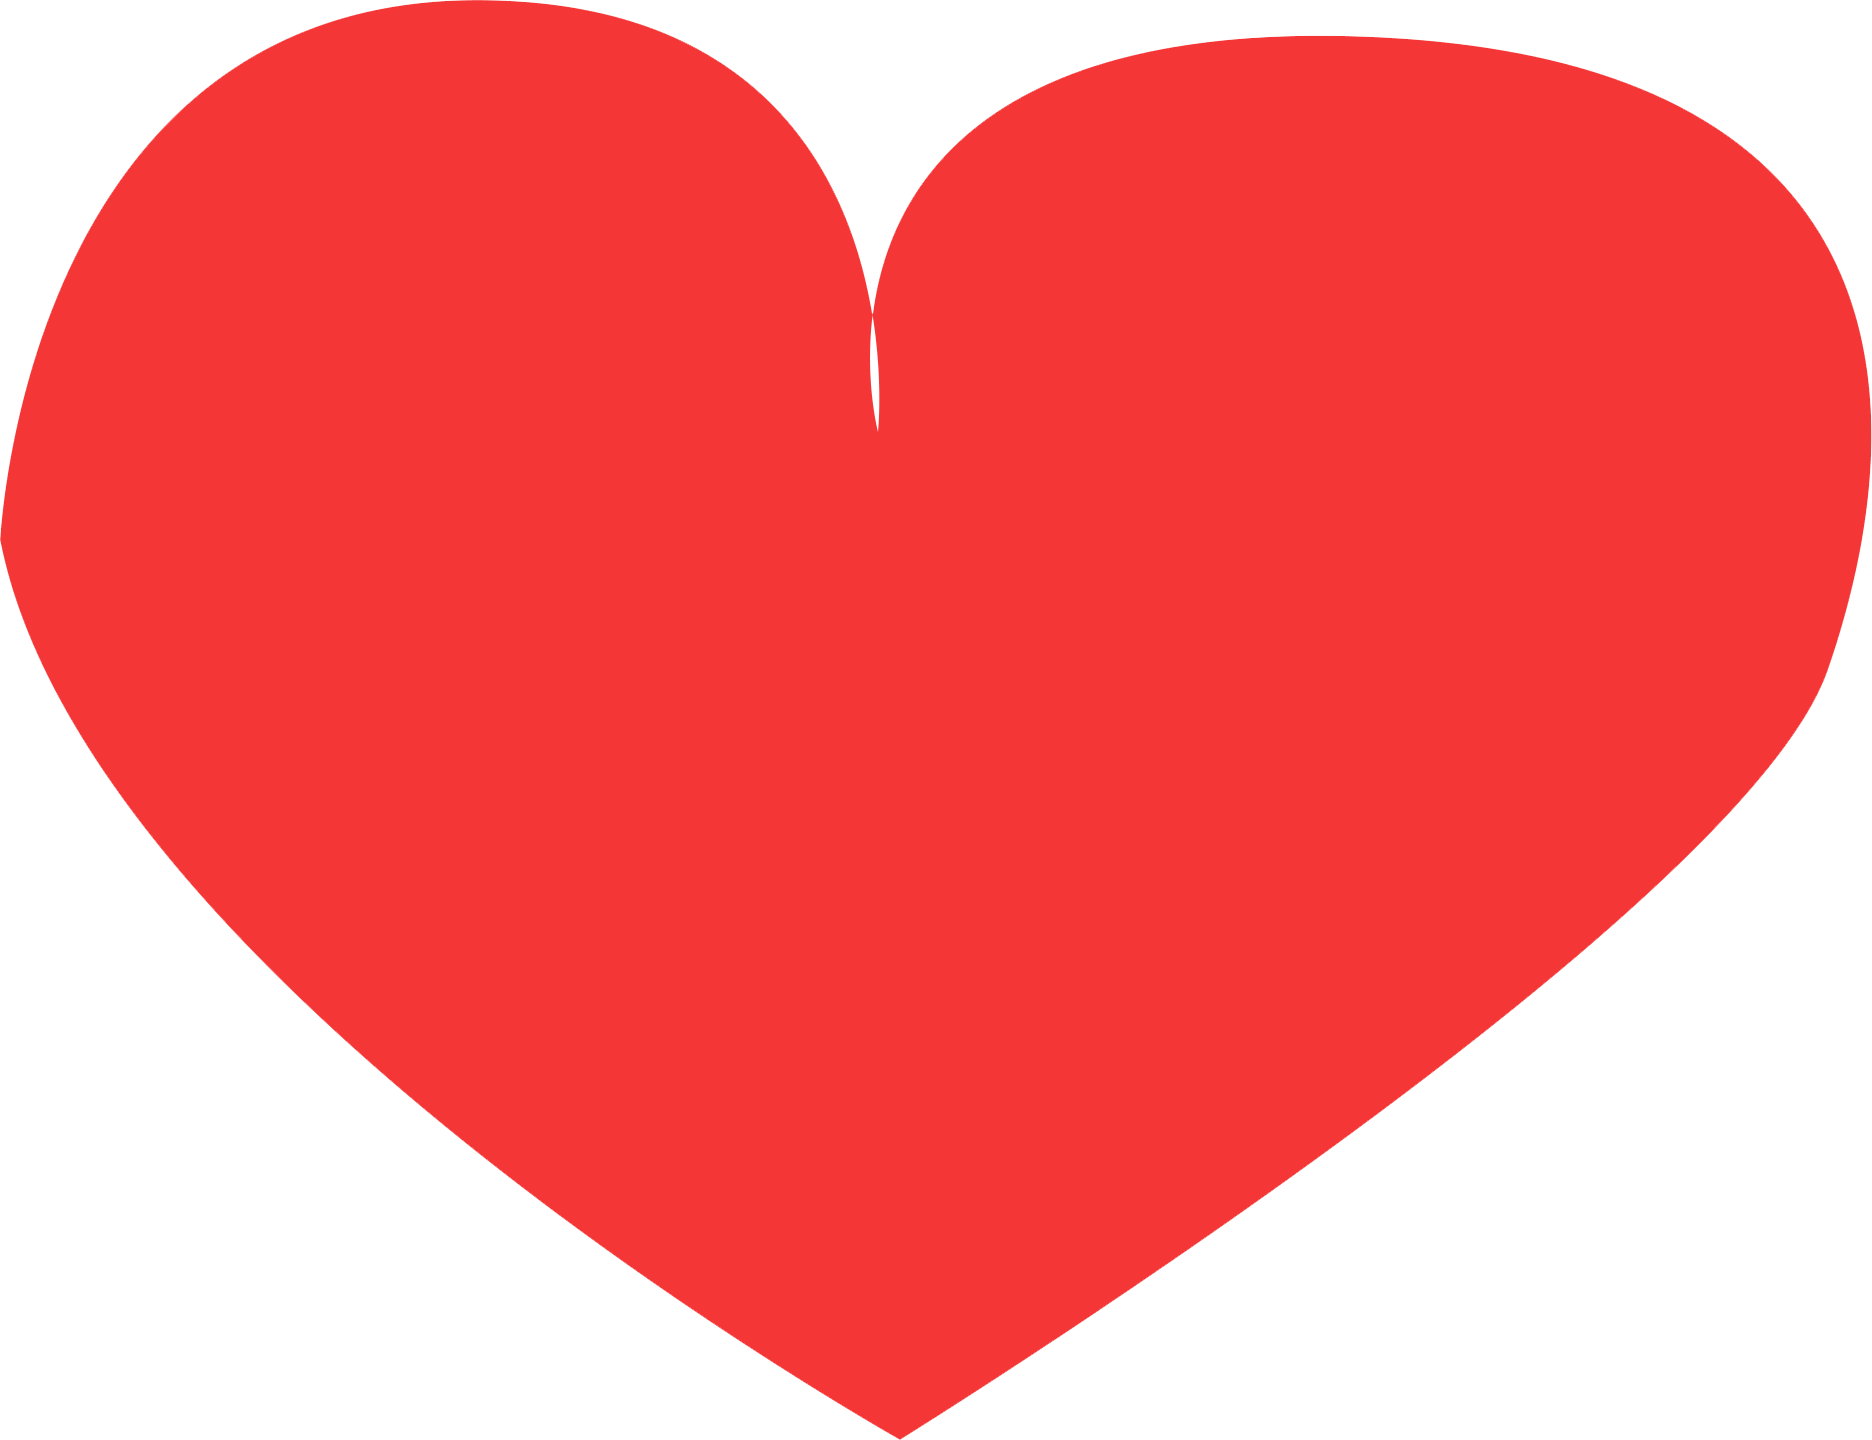

In [18]:
nitems3 = get_nwords(data.query('sentiment==1 and snlp_result==1')['content'].tolist())
c3 = (
    WordCloud()
    .add("",nitems3, word_size_range=[12, 55], mask_image='心形.png')
    .set_global_opts(title_opts=opts.TitleOpts(title="淘宝 词云图",
                     subtitle="对Apple iPhone 13产品评论关键词"))
)
c3.render_notebook()

In [20]:
# 唯品会评论数据分析
data4 = pd.read_excel('唯品会.xlsx')
data4['sentiment'] = data4.star.apply(make_label) #新增一列
data4['snlp_result'] = data4.content.apply(snow_result)

#基本统计
counts4 = 0
for i in range(len(data4)):
    if data4.iloc[i,2] == data4.iloc[i,3]:
        counts4 += 1
print(counts4/len(data4))

data4.head()

0.8131868131868132


,content,star,sentiment,snlp_result
0,从6开始就唯品会买的，起码三四个了不同型号，挺不错的，那么多年了，速度快，东西正品，价格比各...,5,1,1
1,正品非常好,5,1,1
2,唯品实力杠杠的，手机质量完美，比某狗某猫便宜，比较满意的一次购物！而且唯品补差价一点不含糊，...,5,1,1
3,大小合适很适合，单手把玩舒适，轻盈好看，流畅好用，对比了全网价格，这里最实惠，总之非常nice！,5,1,1
4,这拍照真的不同，清晰的很，音质也比普通的手机好得多,5,1,1


In [21]:
key4 = get_pmi(data4['content'].tolist())
aw = bw = cw = 0
for i in key4:
    if i>0:
        aw += 1
    elif i==0:
        bw += 1
    elif i<0:
        cw += 1
print(aw,bw,cw)

('一只', '大拇指', 13.213863652749346)
('一言难尽', '五月', 13.213863652749346)
('三千', '天猫', 13.213863652749346)
('不中用', '千元', 13.213863652749346)
('不乱', '定论', 13.213863652749346)
('不可否认', '至于', 13.213863652749346)
('不太好', '之外', 13.213863652749346)
('不怕', '内存不足', 13.213863652749346)
('不用说', '当前', 13.213863652749346)
('不见', '解决问题', 13.213863652749346)
('中浩', '自然', 13.213863652749346)
('中看', '不中用', 13.213863652749346)
('为何', '单要', 13.213863652749346)
('久仰', '大名', 13.213863652749346)
('之快', '存在', 13.213863652749346)
('九点', '睡觉', 13.213863652749346)
('买下', '人生', 13.213863652749346)
('买个', '一肚子气', 13.213863652749346)
('事物', '新帖', 13.213863652749346)
('二手手机', '送话器', 13.213863652749346)
('京儀', '功菲个', 13.213863652749346)
('人生', '第一台', 13.213863652749346)
('介绍', '好友', 13.213863652749346)
('仓库', '无货', 13.213863652749346)
('令人', '沮丧', 13.213863652749346)
('价格比', '各网', 13.213863652749346)
('传感器', '位移', 13.213863652749346)
('位移', '图像', 13.213863652749346)
('位置', '冷屏', 13.213863652749346)
('借着', '销售', 13.21386


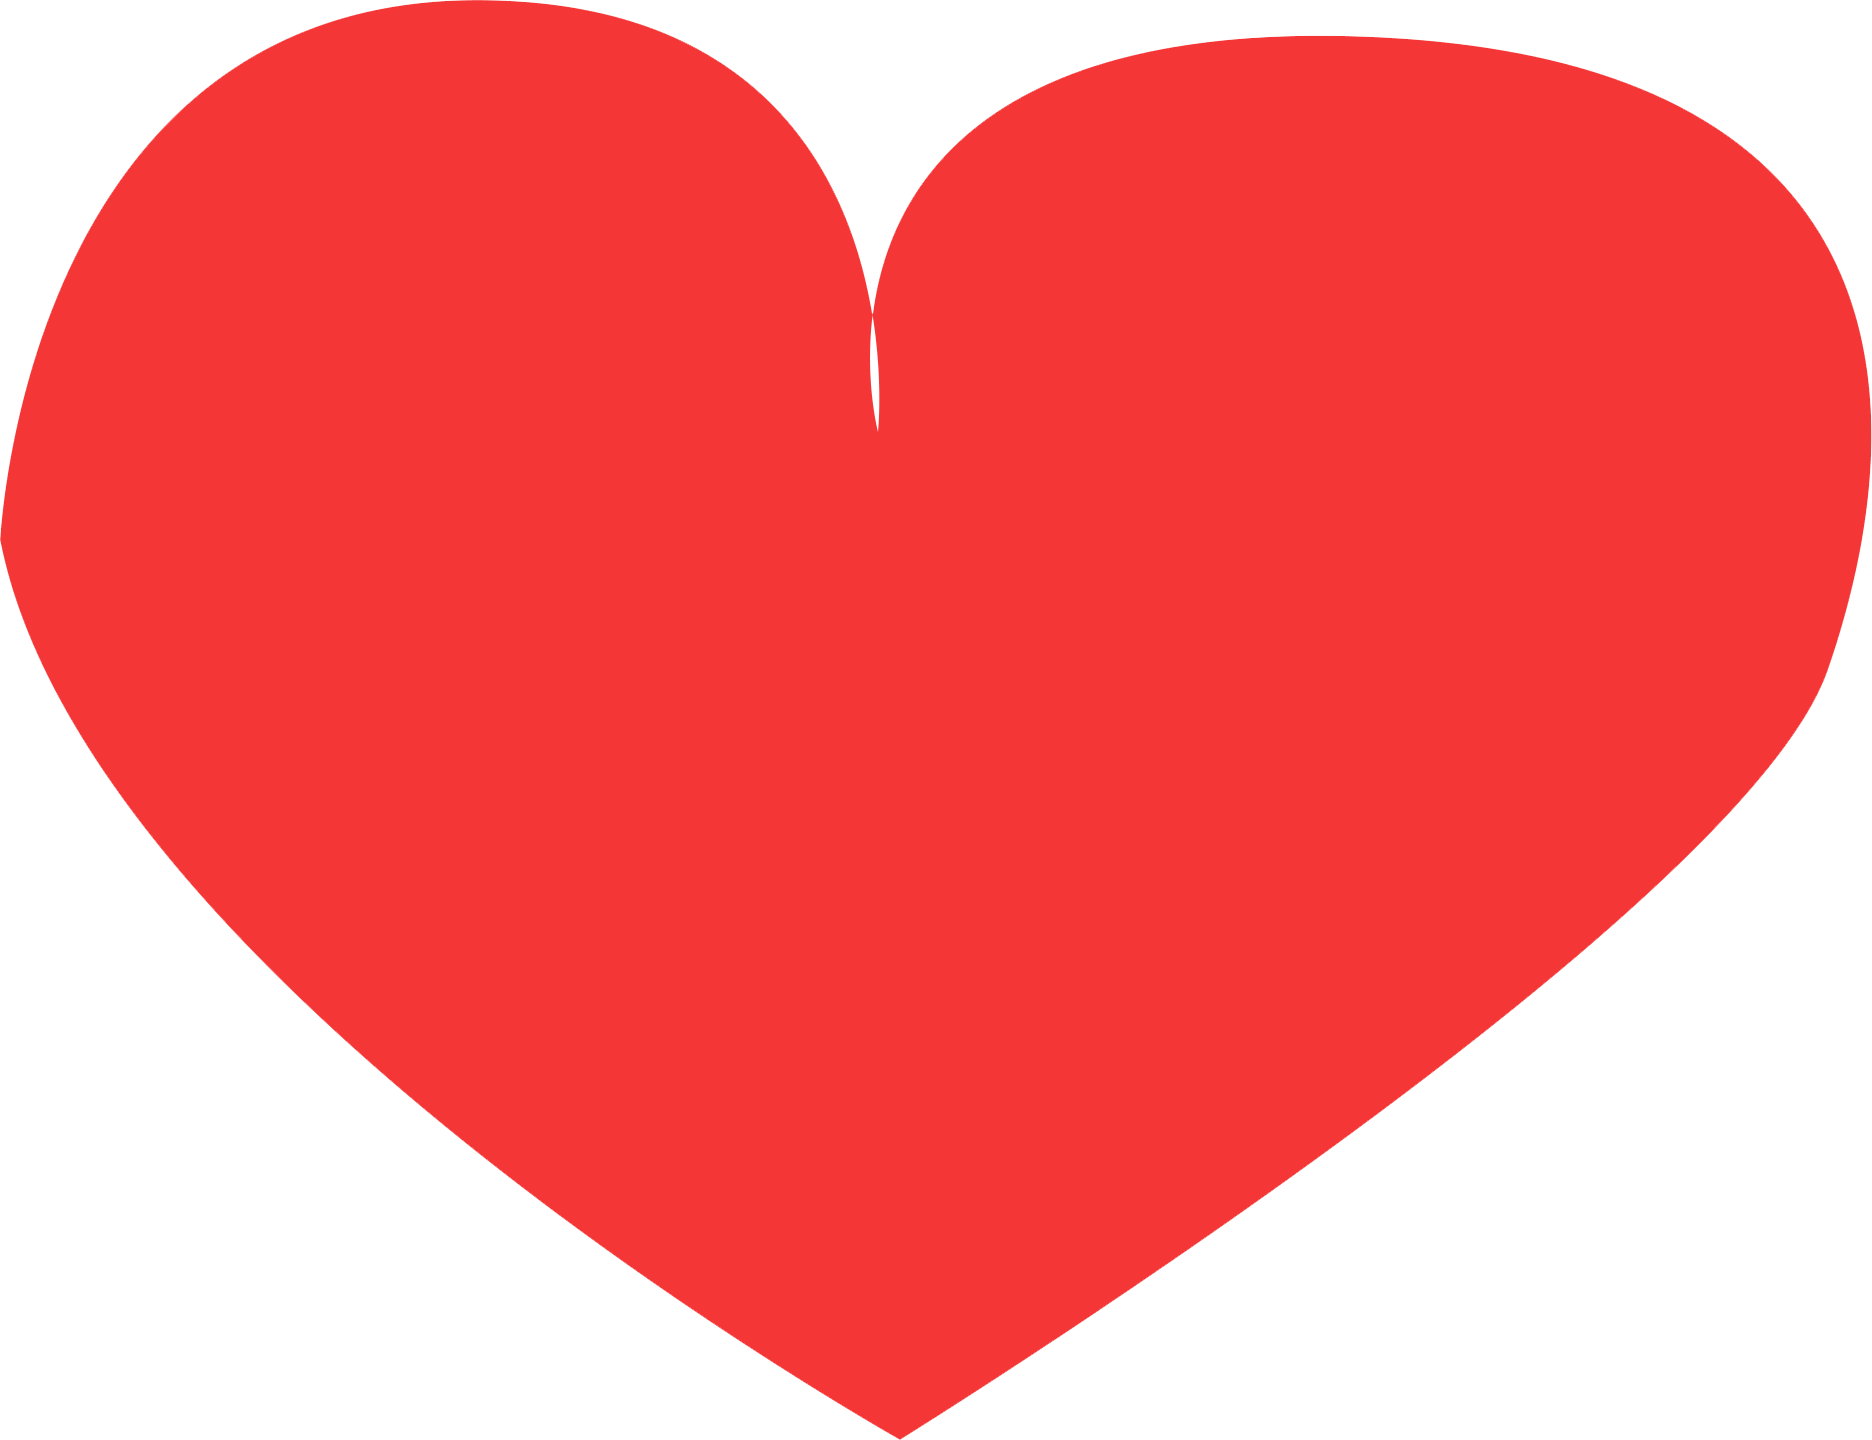

In [22]:
nitems4 = get_nwords(data.query('sentiment==1 and snlp_result==1')['content'].tolist())
c4 = (
    WordCloud()
    .add("",nitems4, word_size_range=[12, 55], mask_image='心形.png')
    .set_global_opts(title_opts=opts.TitleOpts(title="唯品会 词云图",
                     subtitle="对Apple iPhone 13产品评论关键词"))
)
c4.render_notebook()

In [23]:
m = float(data[data.snlp_result==1].snlp_result.count())
n = float(data.shape[0])
p = (m/n*100).__round__(2)

m1 = float(data1[data1.snlp_result==1].snlp_result.count())
n1 = float(data1.shape[0])
p1 = (m1/n1*100).__round__(2)

m2 = float(data3[data3.snlp_result==1].snlp_result.count())
n2 = float(data3.shape[0])
p2 = (m2/n2*100).__round__(2)

m3 = float(data4[data4.snlp_result==1].snlp_result.count())
n3 = float(data4.shape[0])
p3 = (m3/n3*100).__round__(2)
print(p,p1,p2,p3)

42.73 39.09 77.47 60.44


In [24]:
m4 = float(data[data.sentiment==1].sentiment.count())
n4 = float(data.shape[0])
p4 = (m4/n4*100).__round__(2)

m5 = float(data1[data1.sentiment==1].sentiment.count())
n5 = float(data1.shape[0])
p5 = (m5/n5*100).__round__(2)

m6 = float(data4[data4.sentiment==1].sentiment.count())
n6 = float(data4.shape[0])
p6 = (m6/n6*100).__round__(2)

print(p4,p5,p6)

36.36 27.27 57.14


In [25]:
attr=['苏宁易购','京东','唯品会']
v1 = [p,p1,p3]
v2 = [p4,p5,p6]
v3 = []
line=(
    Line(init_opts=opts.InitOpts(height="300px"))
    .add_xaxis(xaxis_data=attr)
    .add_yaxis(
        series_name="snlp_result正面情感占比",
        y_axis=v1,
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
        markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(type_="average", name="平均值")]
        ),
    )
    .add_yaxis(
         series_name="sentiment正面情感占比",
        y_axis=v2,
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
        markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem( name="平均值" ,type_="average")]
        ),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="基于电商评论数据的情感分析")
    )
)
line.render_notebook()